### Imports

In [1]:
import pandas as pd 
import re
import numpy as np 
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

# to get OSM way geometries
import requests 

### Data

In [2]:
tdf = pd.read_csv('data/train-1500.csv')
mdf = pd.read_csv('data/matched_results_1500_updated.csv')
osm_edges = pd.read_csv('data/edges.csv')

### Code w/o `requests`

In [3]:
def linestring_2_locations(x):
    x = re.findall('-?\d+[.]\d+', x)
    if len(x) == 0:
        return np.zeros((0,2))
    x = list(map(float, x))
    x = np.array(x).reshape((-1,2))
    return x

def s2l(x, type):
    if type == int:
        x = re.findall('\d+', x)
    else:
        x = re.findall('-?\d+[.]\d+', x)
    x = list(map(type, x))
    x = np.array(x)
    return x

def to_int(x):
    return s2l(x, int)

def to_float(x):
    return s2l(x, float)

def latlon_to_webmercator(lat, lon, R=6378137):  # Radius in meters
    lat, lon = np.radians(lat), np.radians(lon)
    x = R * lon
    y = R * np.log(np.tan(np.pi / 4 + lat / 2))    
    return x, y


### bounding box

def bbox_overlap(box1, box2):
    min_x1, min_y1, max_x1, max_y1 = box1
    min_x2, min_y2, max_x2, max_y2 = box2    
    horizontal_overlap = min_x1 < max_x2 and max_x1 > min_x2
    vertical_overlap = min_y1 < max_y2 and max_y1 > min_y2    
    overlap = horizontal_overlap and vertical_overlap
    return overlap

def get_padding_bounding_box(xs, ys, padding):
    # get padded bounding box of trajectory
    x_min = np.min(xs) - padding
    x_max = np.max(xs) + padding
    y_min = np.min(ys) - padding
    y_max = np.max(ys) + padding
    bounding_box = (x_min, y_min, x_max, y_max)
    return bounding_box


def merge_bounding_boxes(box1, box2):
    min_x1, min_y1, max_x1, max_y1 = box1
    min_x2, min_y2, max_x2, max_y2 = box2
    return np.min([min_x1,min_x2]), np.min([min_y1, min_y2]), np.max([max_x1, max_x2]), np.max([max_y1, max_y2])  

### get network edges
def get_intersecting_edges(osm_edges, bounding_box):
    edges = []
    for _, row in osm_edges.iterrows():
        edge_trajectory = linestring_2_locations(row.geometry)
        lon, lat = edge_trajectory.T
        xs, ys = latlon_to_webmercator(lat, lon)
        if bbox_overlap((np.min(xs), np.min(ys), np.max(xs), np.max(ys)), bounding_box):
            edges.append([xs, ys])
    return edges

def plot_network(osm_edges, bounding_box, ax):
    edges = get_intersecting_edges(osm_edges, bounding_box)
    parts = []
    for ex, ey in edges:
        temp = ax.plot(ex, ey, '-',c='k', linewidth=.5)# markersize=2)
        parts.extend(temp)
    return parts

def plot_trajectory(xs, ys, ax, color='red'):
    return ax.plot(xs, ys, '-', c=color, linewidth=2, alpha=1, solid_capstyle='round')

def plot_trajectory_on_network(lat, lon, padding, osm_edges, ax):
    # convert lat & lon to x,y
    xs,ys = latlon_to_webmercator(lat, lon)
    bounding_box = get_padding_bounding_box(lat, lon, padding)
    
    x_min, y_min, x_max, y_max = bounding_box
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    
    plot_network(osm_edges, bounding_box, ax)
    plot_trajectory(xs, ys, ax)

### Code using `requests`

In [4]:
WAY_CACHE = {}

def get_way(way_id):
    if way_id in WAY_CACHE:
        return WAY_CACHE[way_id]
    
    OVERPASS_URL = "http://overpass-api.de/api/interpreter"
    query = f'''
    [out:json];
    way({way_id});
    out geom;
    '''
    response = requests.post(OVERPASS_URL, data={"data": query})
    data = response.json()
    way = data['elements'][0]
    WAY_CACHE[way_id] = way
    
    return way

### Visualize match
- converts lon & lat to x & y to that units are in meters
- finds bounding boxes for trajectories
- merges the bounding boxes
- get road network edges intersecting merged bounding box
- plot road network edges
- plot trajectories
- crop to bounding box

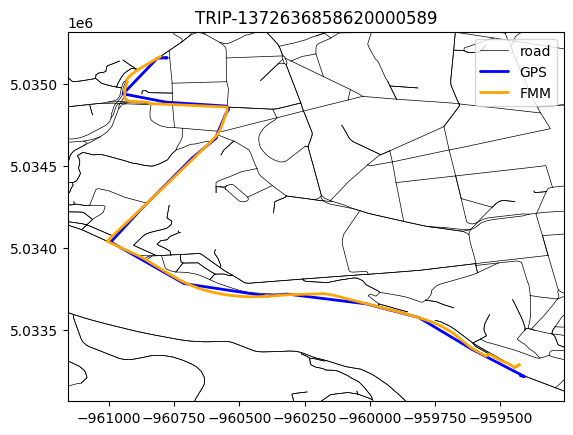

In [5]:
_, ax = plt.subplots(1,1)
bbox_padding = 150 # in meters
idx = 0

# convert string to trajectory
tid = tdf.TRIP_ID.iloc[idx]
gps_path = linestring_2_locations(tdf.POLYLINE.iloc[idx])
match_pts = linestring_2_locations(mdf.match_pt.iloc[idx])
match_geom = linestring_2_locations(mdf.match_geom.iloc[idx])

# get x,y from gps trajectory
lon, lat = gps_path.T
xs1,ys1 = latlon_to_webmercator(lat, lon)
bbox1 = get_padding_bounding_box(xs1, ys1, bbox_padding)

# get x,y from fmm path
lon, lat = match_geom.T
xs2,ys2 = latlon_to_webmercator(lat, lon)
bbox2 = get_padding_bounding_box(xs2, ys2, bbox_padding)

# combine bounding boxes
bbox = merge_bounding_boxes(bbox1, bbox2)

# plot edges intersecting bounding box
t0 = plot_network(osm_edges, bbox, ax)[0]

# plot trajectories for gps
t1, = plot_trajectory(xs1, ys1, ax, color='blue')

# plot trajectories for match
t2, = plot_trajectory(xs2, ys2, ax, color='orange')

# crop to bounding box
x_min, y_min, x_max, y_max = bbox
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

ax.legend([t0, t1, t2], ['road', 'GPS', 'FMM'])
ax.set_title('TRIP-'+str(tid))
# ax.axis('off')
plt.show()

### Analysis

In [7]:
way_time_score = defaultdict(lambda: 0)
edge_time_score = defaultdict(lambda: 0)

for match in mdf.match_edge_by_pt:
    for eid in to_int(match):
        e = osm_edges.iloc[eid]
        edge_time_score[eid] += 15
        for way_id in to_int(e.osmid):
            way_time_score[way_id] += 15        

In [8]:
entries = []
for k in way_time_score.keys():
    total_time = way_time_score[k]
    entries.append([k, total_time])
top_n = heapq.nlargest(10, entries, key=lambda el: el[1])
top_n

[[715176796, 5220],
 [190128487, 5055],
 [479187303, 4680],
 [398030856, 4680],
 [479127849, 4680],
 [479127848, 4680],
 [479192145, 4680],
 [35047581, 4680],
 [35047582, 4680],
 [210851328, 4380]]

### Viz top 10

**TOFIX**
- some edges are associated with multiple nested way ids

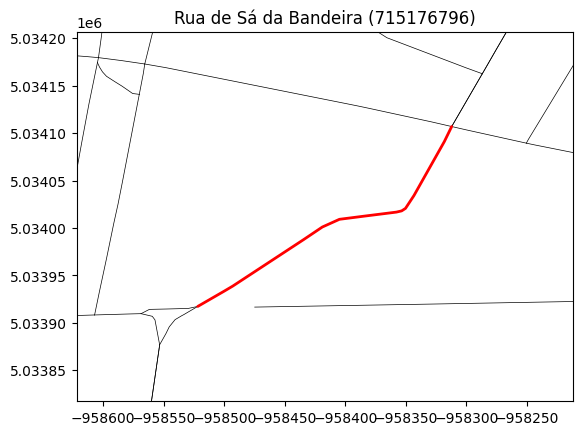

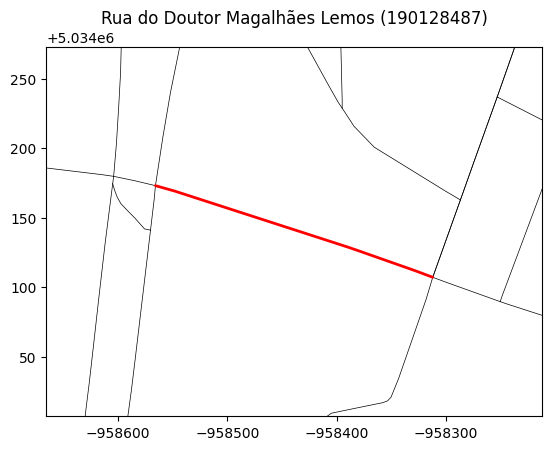

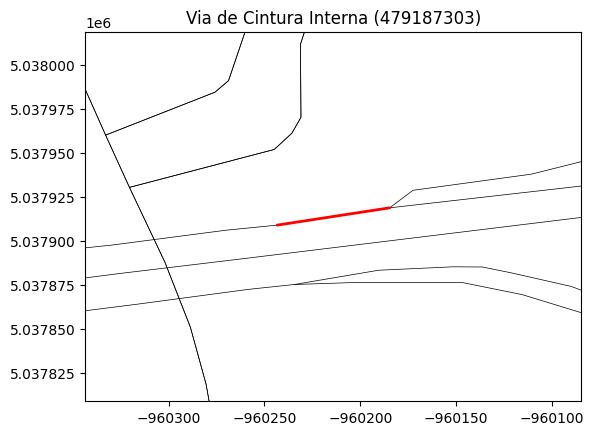

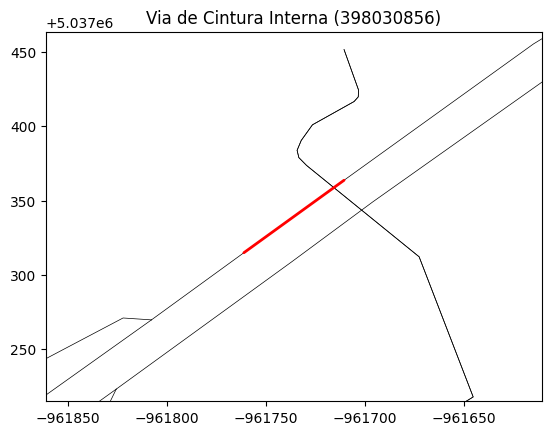

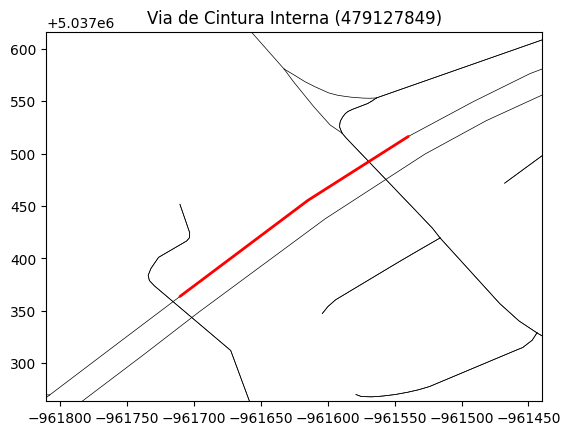

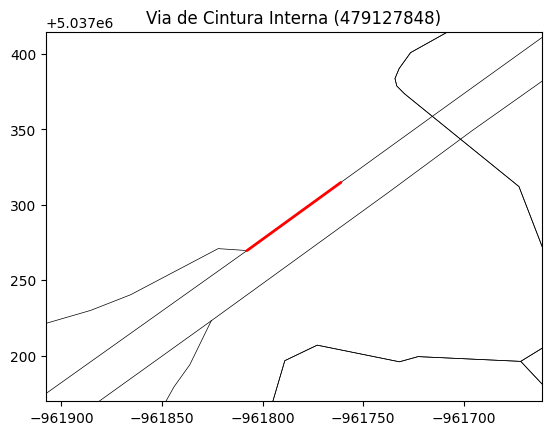

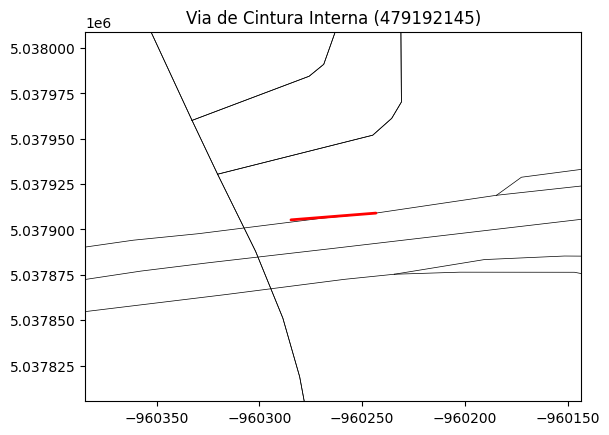

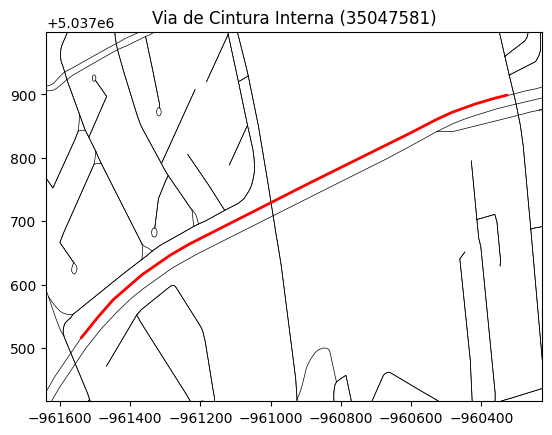

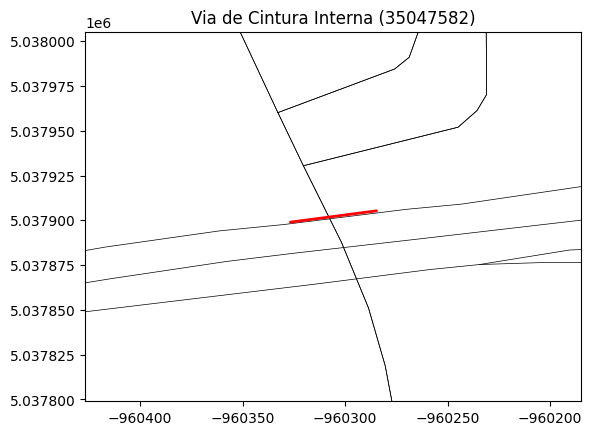

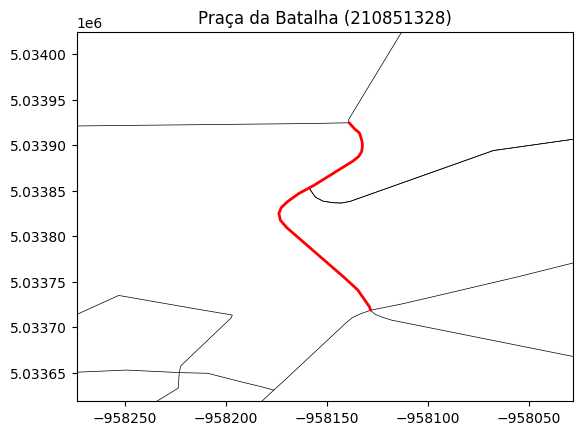

In [9]:
for way_id, _ in top_n:
    way = get_way(way_id)
    g = pd.DataFrame(way['geometry'])    
    xs,ys = latlon_to_webmercator(g.lat, g.lon)
    bounding_box = get_padding_bounding_box(xs, ys, 100)
    x_min, y_min, x_max, y_max = bounding_box

    _, ax = plt.subplots(1,1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    plot_network(osm_edges, bounding_box, ax)
    plot_trajectory(xs, ys, ax)
    way_name = way['tags']['name']
    title = f'{way_name} ({way_id})'
    plt.title(title)
    plt.show()